# Customer segmentation

From a datasaet with many customer interactions, find some insights to help with the task of segmenting customers in a useful way.

Conclusion: the algorithm used predicts future consumption behavior from previous purchases, which is impressive.

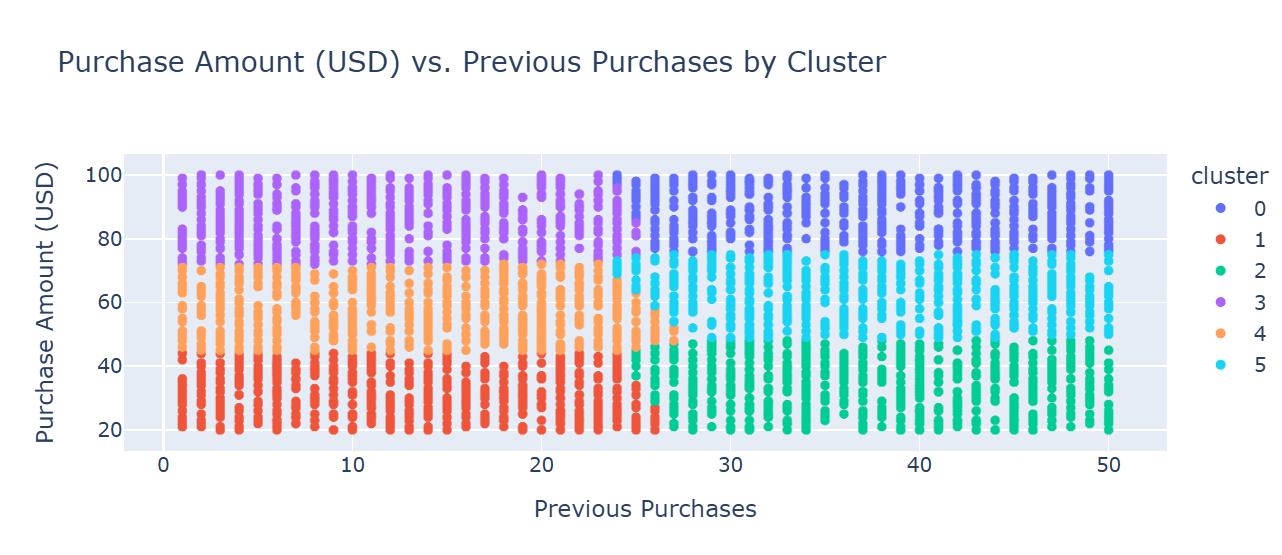

# Libraries

In [146]:
import numpy as np
import pandas as pd
import itertools

import matplotlib.pyplot as plt  # Graphics (normal)
plt.style.use('seaborn-v0_8') # Style for matplotlib charts (optional, but makes easier to read charts)
plt.rcParams['figure.figsize'] = [9.3, 3.5] # Size for matplotlib charts (optional, but useful) 

import plotly.express as px  # Graphics (more options and interactivity)
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from datetime import datetime, timedelta  # Dealing with data

from sklearn.preprocessing import LabelBinarizer, OneHotEncoder, MinMaxScaler  # For one-hot encoding

from scipy.stats import shapiro, normaltest # normality test for smaller (shapiro) and larger (normaltest) samples

from sklearn.cluster import DBSCAN # Group observations into clusters of high-density, number of clusters unknown
from sklearn.cluster import MeanShift # Clustering without assuming number of clusters
from sklearn.cluster import KMeans  # A number of clusters must be given beforehand

from sklearn.metrics import silhouette_score, davies_bouldin_score # Metrics for clustering models

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

# Data import

In [147]:
sales = pd.read_csv(r'C:\Arquivos\Fermin\2023-12_Aprender\Machine Learning\Proyecto - Customer segmentation\shopping customers dataset.csv')

In [148]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Customer ID             3900 non-null   int64  
 1   Age                     3900 non-null   int64  
 2   Gender                  3900 non-null   object 
 3   Item Purchased          3900 non-null   object 
 4   Category                3900 non-null   object 
 5   Purchase Amount (USD)   3900 non-null   int64  
 6   Location                3900 non-null   object 
 7   Size                    3900 non-null   object 
 8   Color                   3900 non-null   object 
 9   Season                  3900 non-null   object 
 10  Review Rating           3900 non-null   float64
 11  Subscription Status     3900 non-null   object 
 12  Shipping Type           3900 non-null   object 
 13  Discount Applied        3900 non-null   object 
 14  Promo Code Used         3900 non-null   

In [149]:
sales.isna().sum()

Customer ID               0
Age                       0
Gender                    0
Item Purchased            0
Category                  0
Purchase Amount (USD)     0
Location                  0
Size                      0
Color                     0
Season                    0
Review Rating             0
Subscription Status       0
Shipping Type             0
Discount Applied          0
Promo Code Used           0
Previous Purchases        0
Payment Method            0
Frequency of Purchases    0
dtype: int64

In [150]:
sales.describe().T

,count,mean,std,min,25%,50%,75%,max
Customer ID,3900.0,1950.500000,1125.977353,1.0,975.75,1950.5,2925.25,3900.0
Age,3900.0,44.068462,15.207589,18.0,31.00,44.0,57.00,70.0
Purchase Amount (USD),3900.0,59.764359,23.685392,20.0,39.00,60.0,81.00,100.0
Review Rating,3900.0,3.749949,0.716223,2.5,3.10,3.7,4.40,5.0
Previous Purchases,3900.0,25.351538,14.447125,1.0,13.00,25.0,38.00,50.0


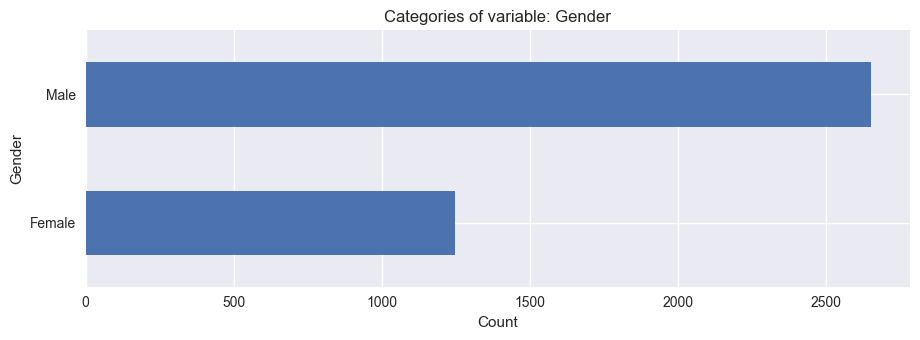

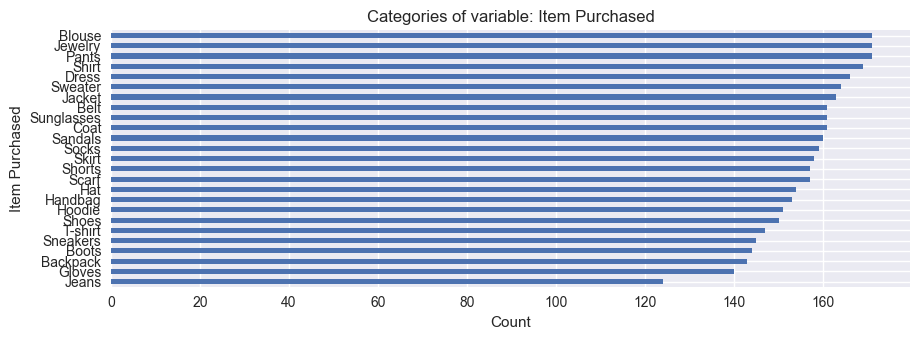

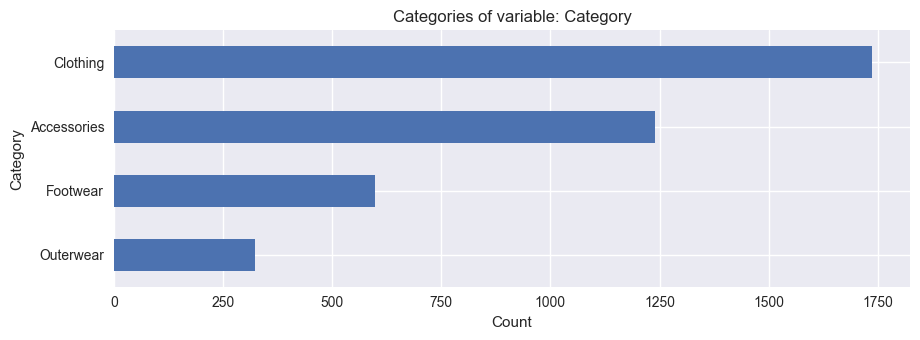

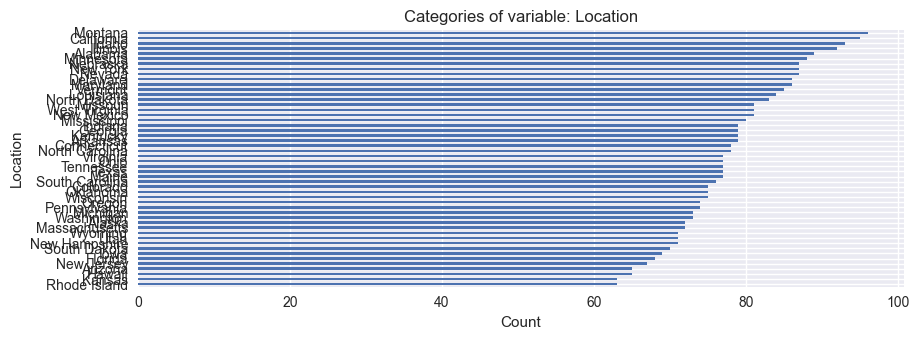

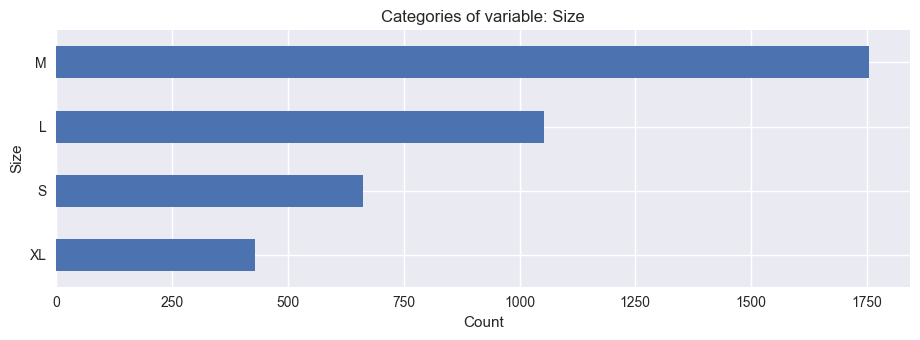

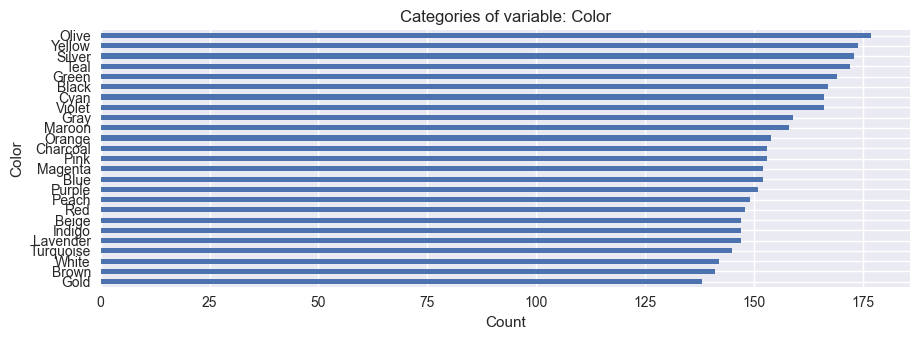

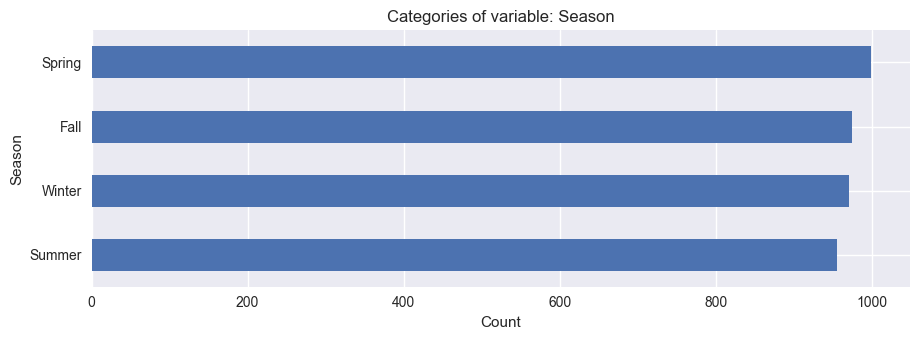

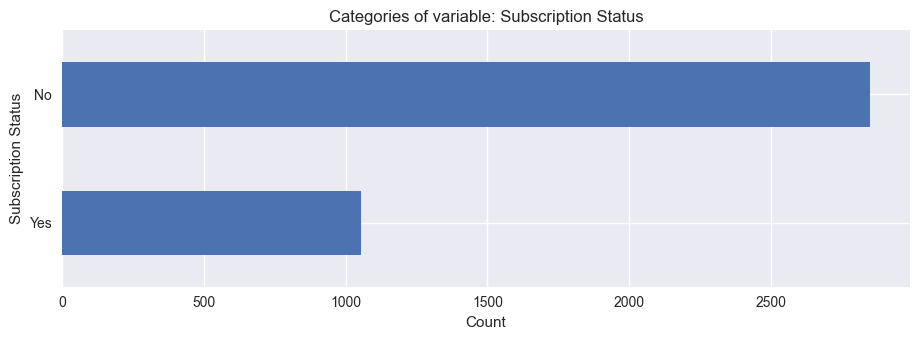

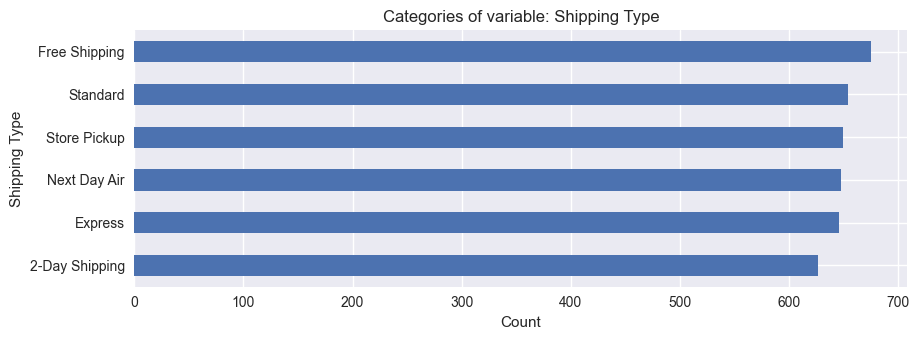

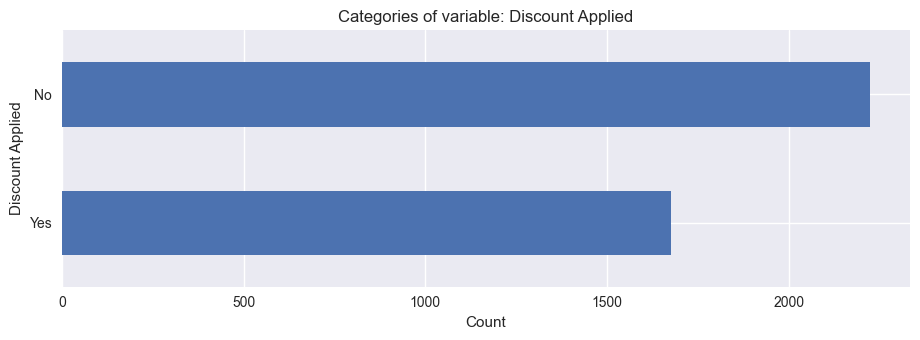

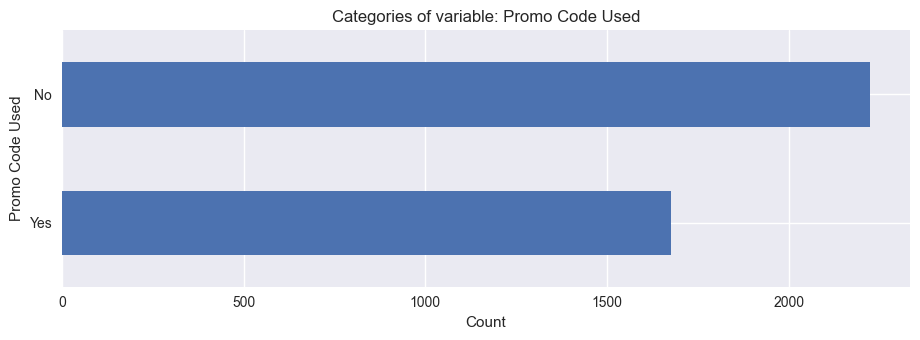

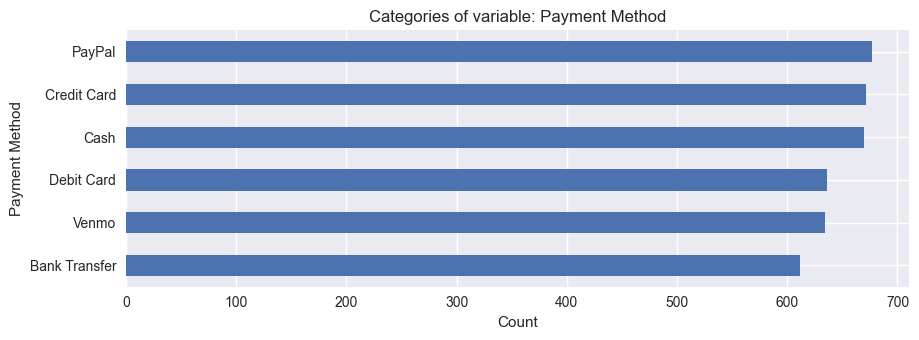

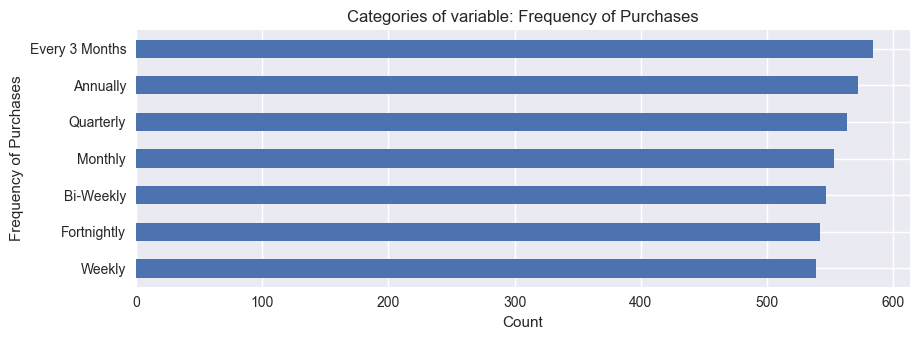

In [151]:
for column in sales.select_dtypes(include='object').columns:
    plt.figure()
    sales[column].value_counts().sort_values().plot(kind='barh')
    plt.title(f'Categories of variable: {column}')
    plt.xlabel('Count')
    #plt.ylabel('Categories')
    plt.tight_layout()
    plt.show()

Analysis of non-numerical data:

- Gender: relevant
- Item Purchased: too much granularity, to drop
- Category: relevant
- Location: too many, to group in 5 categories or so
- Size: relevant
- Color: too much granularity, to drop
- Season: relevant
- Suscription Status: Yes/No
- Shipping type: relevant
- Discount Applied: Yes/No
- Promo Code Used: Yes/No... check equivalence to Discount Applied
- Payment Method: relevant
- Frequency of Purchases: relevant

# Data transformation

Creating working dataframe, keeping original data safe

In [152]:
df = sales.copy()

df.columns

Index(['Customer ID', 'Age', 'Gender', 'Item Purchased', 'Category',
       'Purchase Amount (USD)', 'Location', 'Size', 'Color', 'Season',
       'Review Rating', 'Subscription Status', 'Shipping Type',
       'Discount Applied', 'Promo Code Used', 'Previous Purchases',
       'Payment Method', 'Frequency of Purchases'],
      dtype='object')

Eliminating columns

In [153]:
df = df[['Customer ID', 'Age', 'Gender', 
    #'Item Purchased', 
    'Category',
       'Purchase Amount (USD)', 'Location', 'Size', 
    #'Color', 
    'Season',
       'Review Rating', 'Subscription Status', 'Shipping Type',
       'Discount Applied', 'Promo Code Used', 'Previous Purchases',
       'Payment Method', 'Frequency of Purchases']]

Checking if two columns are repeated

In [154]:
(df['Discount Applied'] == df['Promo Code Used']).mean()

1.0

In [155]:
df = df.drop(columns='Promo Code Used')

Verifying that rows are not repeated

In [156]:
df.shape

(3900, 15)

In [157]:
df['Customer ID'].nunique()

3900

Grouping Location in fewer areas

In [158]:
#specify the locations by location groups
location_group_dict = { 
    'Far West': ['Alaska', 'California', 'Hawaii', 'Nevada', 'Oregon', 'Washington'],
    'Great Lakes': ['Illinois', 'Indiana', 'Michigan', 'Ohio', 'Wisconsin'],
    'Mideast': ['Delaware', 'District of Columbia', 'Maryland', 'New Jersey', 'New York', 'Pennsylvania'],
    'New England': ['Connecticut', 'Maine', 'Massachusetts', 'New Hampshire', 'Rhode Island', 'Vermont'],
    'Plains': ['Iowa', 'Kansas', 'Minnesota', 'Missouri', 'Nebraska', 'North Dakota', 'South Dakota'],
    'Rocky Mountains': ['Colorado', 'Idaho', 'Montana', 'Utah', 'Wyoming'],
    'Southeast': ['Alabama', 'Arkansas', 'Florida', 'Georgia', 'Kentucky', 'Louisiana', 'Mississippi', 'North Carolina', 'South Carolina', 'Tennessee', 'Virginia', 'West Virginia'],
    'Southwest': ['Arizona', 'New Mexico', 'Oklahoma', 'Texas'] }

#Create a state to region dictionary
location_to_location_group = {location: location_group for location_group, locations in location_group_dict.items() for location in locations}

#Create new regions column
location_group_col = df['Location'].map(lambda location: location_to_location_group.get(location))

In [159]:
df['Location'] = location_group_col

In [160]:
df.Location.value_counts()

Location
Southeast          947
Plains             541
Far West           466
New England        446
Rocky Mountains    406
Mideast            400
Great Lakes        396
Southwest          298
Name: count, dtype: int64

## Hot-encoding categorical variables

I will hot-encode all the categorical variables, even though column showing purchasing frequency could have been encoded in a different way

In [161]:
df.select_dtypes(include='object').columns

Index(['Gender', 'Category', 'Location', 'Size', 'Season',
       'Subscription Status', 'Shipping Type', 'Discount Applied',
       'Payment Method', 'Frequency of Purchases'],
      dtype='object')

In [162]:
columns_for_one_hot_encoder = df.select_dtypes(include='object').columns.to_numpy()

# Initialize encoder (sparse output is default)
one_hot_encoder = OneHotEncoder()

# Fit and transform
sparse_matrix_one_hot_encoder = one_hot_encoder.fit_transform(df[columns_for_one_hot_encoder])

# Get column names
one_hot_encoder_column_names = one_hot_encoder.get_feature_names_out(columns_for_one_hot_encoder)

# Convert to sparse DataFrame
sparse_one_hot_encoder_df = pd.DataFrame.sparse.from_spmatrix(sparse_matrix_one_hot_encoder, 
                                columns=one_hot_encoder_column_names)

In [163]:
sparse_one_hot_encoder_df.head()

,Gender_Female,Gender_Male,Category_Accessories,Category_Clothing,Category_Footwear,Category_Outerwear,Location_Far West,Location_Great Lakes,Location_Mideast,Location_New England,...,Payment Method_Debit Card,Payment Method_PayPal,Payment Method_Venmo,Frequency of Purchases_Annually,Frequency of Purchases_Bi-Weekly,Frequency of Purchases_Every 3 Months,Frequency of Purchases_Fortnightly,Frequency of Purchases_Monthly,Frequency of Purchases_Quarterly,Frequency of Purchases_Weekly
0,0,1.0,0,1.0,0,0,0,0,0,0,...,0,0,1.0,0,0,0,1.0,0,0,0
1,0,1.0,0,1.0,0,0,0,0,0,1.0,...,0,0,0,0,0,0,1.0,0,0,0
2,0,1.0,0,1.0,0,0,0,0,0,1.0,...,0,0,0,0,0,0,0,0,0,1.0
3,0,1.0,0,0,1.0,0,0,0,0,1.0,...,0,1.0,0,0,0,0,0,0,0,1.0
4,0,1.0,0,1.0,0,0,1.0,0,0,0,...,0,1.0,0,1.0,0,0,0,0,0,0


In [164]:
sparse_one_hot_encoder_df.columns

Index(['Gender_Female', 'Gender_Male', 'Category_Accessories',
       'Category_Clothing', 'Category_Footwear', 'Category_Outerwear',
       'Location_Far West', 'Location_Great Lakes', 'Location_Mideast',
       'Location_New England', 'Location_Plains', 'Location_Rocky Mountains',
       'Location_Southeast', 'Location_Southwest', 'Size_L', 'Size_M',
       'Size_S', 'Size_XL', 'Season_Fall', 'Season_Spring', 'Season_Summer',
       'Season_Winter', 'Subscription Status_No', 'Subscription Status_Yes',
       'Shipping Type_2-Day Shipping', 'Shipping Type_Express',
       'Shipping Type_Free Shipping', 'Shipping Type_Next Day Air',
       'Shipping Type_Standard', 'Shipping Type_Store Pickup',
       'Discount Applied_No', 'Discount Applied_Yes',
       'Payment Method_Bank Transfer', 'Payment Method_Cash',
       'Payment Method_Credit Card', 'Payment Method_Debit Card',
       'Payment Method_PayPal', 'Payment Method_Venmo',
       'Frequency of Purchases_Annually', 'Frequency of Pu

## Min-Max encoding numerical columns

In [165]:
df.loc[:, ~df.columns.isin(columns_for_one_hot_encoder)].columns

Index(['Customer ID', 'Age', 'Purchase Amount (USD)', 'Review Rating',
       'Previous Purchases'],
      dtype='object')

In [166]:
columns_for_minmax_scaler = ['Age', 'Purchase Amount (USD)', 'Review Rating',
       'Previous Purchases']

# Initialize encoder
minmax_scaler = MinMaxScaler()

# Fit and transform
matrix_minmax_scaler = minmax_scaler.fit_transform(df[columns_for_minmax_scaler])

# Get column names
minmax_scaler_column_names = minmax_scaler.get_feature_names_out()

# Convert to sparse DataFrame
minmax_scaler_df = pd.DataFrame(matrix_minmax_scaler, 
                                columns=minmax_scaler_column_names)

In [167]:
minmax_scaler_df

,Age,Purchase Amount (USD),Review Rating,Previous Purchases
0,0.711538,0.4125,0.24,0.265306
1,0.019231,0.5500,0.24,0.020408
2,0.615385,0.6625,0.24,0.448980
3,0.057692,0.8750,0.40,0.979592
4,0.519231,0.3625,0.08,0.612245
...,...,...,...,...
3895,0.423077,0.1000,0.68,0.632653
3896,0.653846,0.3625,0.80,0.816327
3897,0.538462,0.1625,0.16,0.469388
3898,0.500000,0.7125,0.52,0.469388


In [168]:
round(minmax_scaler_df.describe(),3).T

,count,mean,std,min,25%,50%,75%,max
Age,3900.0,0.501,0.292,0.0,0.250,0.50,0.750,1.0
Purchase Amount (USD),3900.0,0.497,0.296,0.0,0.238,0.50,0.762,1.0
Review Rating,3900.0,0.500,0.286,0.0,0.240,0.48,0.760,1.0
Previous Purchases,3900.0,0.497,0.295,0.0,0.245,0.49,0.755,1.0


### Checking normality of variables

In [169]:
results = {}

for column in minmax_scaler_df.columns:
    stat, p = normaltest(minmax_scaler_df[column].dropna())  # Drop NaNs for safety
    results[column] = {'statistic': stat, 'p_value': p}

# Convert to DataFrame for easy viewing
normality_df = pd.DataFrame(results).T

print('Low p values (< 0.05) indicate a normal distribution:')
print(normality_df)


Low p values (< 0.05) indicate a normal distribution:
                         statistic  p_value
Age                    3145.262803      0.0
Purchase Amount (USD)  4715.938064      0.0
Review Rating          2761.916711      0.0
Previous Purchases     3015.371781      0.0


## Joining all data

In [170]:
customer_id_df = df[['Customer ID']]

In [171]:
df_clustering = pd.concat([customer_id_df, minmax_scaler_df, sparse_one_hot_encoder_df], axis=1)

In [172]:
df_clustering = df_clustering.set_index('Customer ID')


# Segmentation

## DBSCAN

First try with DBSCAN, where no number of clusters is to be supposed

In [173]:
# Create DBSCAN object
cluster_DBSCAN = DBSCAN(n_jobs=-1, min_samples=50)

# Train model
model_cluster_DBSCAN = cluster_DBSCAN.fit(df_clustering)

In [174]:
model_cluster_DBSCAN.labels_

array([-1, -1, -1, ..., -1, -1, -1], dtype=int64)

In [175]:
np.unique(model_cluster_DBSCAN.labels_)

array([-1], dtype=int64)

In [176]:
unique_values, counts = np.unique(model_cluster_DBSCAN.labels_, return_counts=True)

# Combine into a dictionary (optional)
value_counts = dict(zip(unique_values, counts))

print(value_counts)


{-1: 3900}


The model did not work.

## MeanShift

In [177]:
# Create MeanShift object
cluster_meanshift = MeanShift(n_jobs=-1, max_iter=1000, cluster_all=False)

# Train model
model_cluster_meanshift = cluster_meanshift.fit(df_clustering)

In [178]:
model_cluster_meanshift.labels_

array([0, 0, 0, ..., 0, 0, 0])

In [179]:
np.unique(model_cluster_meanshift.labels_)

array([0])

Model did not work out

## K Means

In [180]:
# Create k-means object
cluster_kmeans_2 = KMeans(n_clusters=2, random_state=0, n_init="auto")
# Train model
model_cluster_kmeans_2 = cluster_kmeans_2.fit(df_clustering)

In [181]:
model_cluster_kmeans_2.labels_

array([1, 1, 1, ..., 1, 0, 0])

In [182]:
unique_values, counts = np.unique(model_cluster_kmeans_2.labels_, return_counts=True)

# Combine into a dictionary (optional)
value_counts = dict(zip(unique_values, counts))

print(value_counts)

{0: 2076, 1: 1824}


In [183]:
# Create k-means object
cluster_kmeans_3 = KMeans(n_clusters=3, random_state=0, n_init="auto")
# Train model
model_cluster_kmeans_3 = cluster_kmeans_3.fit(df_clustering)

unique_values, counts = np.unique(model_cluster_kmeans_3.labels_, return_counts=True)

# Combine into a dictionary (optional)
value_counts = dict(zip(unique_values, counts))

print(value_counts)

{0: 1217, 1: 1006, 2: 1677}


In [184]:
# Create k-means object
cluster_kmeans_4 = KMeans(n_clusters=4, random_state=0, n_init="auto")
# Train model
model_cluster_kmeans_4 = cluster_kmeans_4.fit(df_clustering)

unique_values, counts = np.unique(model_cluster_kmeans_4.labels_, return_counts=True)

# Combine into a dictionary (optional)
value_counts = dict(zip(unique_values, counts))

print(value_counts)

{0: 875, 1: 724, 2: 1053, 3: 1248}


In [185]:
# Create k-means object
cluster_kmeans_5 = KMeans(n_clusters=5, random_state=0, n_init="auto")
# Train model
model_cluster_kmeans_5 = cluster_kmeans_5.fit(df_clustering)

unique_values, counts = np.unique(model_cluster_kmeans_5.labels_, return_counts=True)

# Combine into a dictionary (optional)
value_counts = dict(zip(unique_values, counts))

print(value_counts)

{0: 514, 1: 415, 2: 1053, 3: 1248, 4: 670}


In [186]:
# Create k-means object
cluster_kmeans_6 = KMeans(n_clusters=6, random_state=0, n_init="auto")
# Train model
model_cluster_kmeans_6 = cluster_kmeans_6.fit(df_clustering)

unique_values, counts = np.unique(model_cluster_kmeans_6.labels_, return_counts=True)

# Combine into a dictionary (optional)
value_counts = dict(zip(unique_values, counts))

print(value_counts)

{0: 404, 1: 439, 2: 624, 3: 1141, 4: 239, 5: 1053}


In [187]:
# Create k-means object
cluster_kmeans_7 = KMeans(n_clusters=7, random_state=0, n_init="auto")
# Train model
model_cluster_kmeans_7 = cluster_kmeans_7.fit(df_clustering)

unique_values, counts = np.unique(model_cluster_kmeans_7.labels_, return_counts=True)

# Combine into a dictionary (optional)
value_counts = dict(zip(unique_values, counts))

print(value_counts)

{0: 305, 1: 439, 2: 624, 3: 556, 4: 231, 5: 1053, 6: 692}


In [188]:

X = df_clustering  # your feature matrix
cluster_range = range(2, 11)
results = []

for k in cluster_range:
    model = KMeans(n_clusters=k, random_state=888)
    labels = model.fit_predict(X)
    
    inertia = model.inertia_  # Sum of squared distances to cluster centers
    silhouette = silhouette_score(X, labels)  # How well-separated the clusters are
    
    results.append({'k': k, 'inertia': inertia, 'silhouette': silhouette})

results_df = pd.DataFrame(results)
print(results_df)

    k       inertia  silhouette
0   2  24595.462873    0.113155
1   3  23471.152798    0.080926
2   4  22703.939445    0.077236
3   5  22459.506392    0.064307
4   6  22024.345051    0.052206
5   7  21752.286462    0.052585
6   8  21424.188719    0.048383
7   9  21293.108886    0.046397
8  10  21139.836265    0.043677


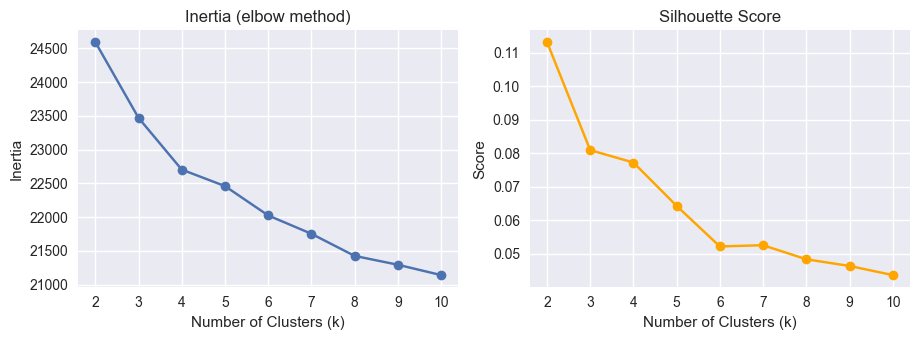

In [189]:
# Elbow method (inertia)
plt.subplot(1, 2, 1) # rows, columns, index
plt.plot(results_df['k'], results_df['inertia'], marker='o')
plt.title('Inertia (elbow method)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')

# Silhouette score
plt.subplot(1, 2, 2) # rows, columns, index
plt.plot(results_df['k'], results_df['silhouette'], marker='o', color='orange')
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Score')

plt.tight_layout()
plt.show()


How to interpret these charts:

- Inertia: Look for the "elbow" point where inertia stops decreasing sharply.
- Silhouette score: Higher is better (max = 1). Indicates well-separated clusters.

Number of clusters chosen: 4

## First results

Creating the model

In [190]:
# Create k-means object
cluster_kmeans_4 = KMeans(n_clusters=4, random_state=0, n_init="auto")
# Train model
model_cluster_kmeans_4 = cluster_kmeans_4.fit(df_clustering)

unique_values, counts = np.unique(model_cluster_kmeans_4.labels_, return_counts=True)

# Combine into a dictionary (optional)
value_counts = dict(zip(unique_values, counts))

print(value_counts)

{0: 875, 1: 724, 2: 1053, 3: 1248}


Assigning the labels to the original dataframe

In [191]:
# Predict cluster labels
labels = model_cluster_kmeans_4.predict(df_clustering)

# Add labels to the DataFrame
df_clustering['cluster'] = labels


In [192]:
df_clustering.cluster.value_counts()

cluster
3    1248
2    1053
0     875
1     724
Name: count, dtype: int64

In [193]:
sorted(df_clustering.cluster.unique())

[0, 1, 2, 3]

In [194]:
for cluster in sorted(df_clustering.cluster.unique()):
    print(f'Cluster: {cluster}')
    print(df_clustering.loc[df_clustering.cluster == cluster].sum())
    print()

Cluster: 0
Age                                      439.846154
Purchase Amount (USD)                       430.475
Review Rating                                 447.4
Previous Purchases                       446.040816
Gender_Female                                     0
Gender_Male                                   875.0
Category_Accessories                          514.0
Category_Clothing                                 0
Category_Footwear                             229.0
Category_Outerwear                            132.0
Location_Far West                             116.0
Location_Great Lakes                           90.0
Location_Mideast                               85.0
Location_New England                          102.0
Location_Plains                               123.0
Location_Rocky Mountains                       89.0
Location_Southeast                            206.0
Location_Southwest                             64.0
Size_L                                        216.0
S

Even without analysis with real values the numeric features, we can see that shipping, size, season and payment are not that relevant.

Let's remake the calculation dropping those columns

In [195]:
df_clustering.columns

Index(['Age', 'Purchase Amount (USD)', 'Review Rating', 'Previous Purchases',
       'Gender_Female', 'Gender_Male', 'Category_Accessories',
       'Category_Clothing', 'Category_Footwear', 'Category_Outerwear',
       'Location_Far West', 'Location_Great Lakes', 'Location_Mideast',
       'Location_New England', 'Location_Plains', 'Location_Rocky Mountains',
       'Location_Southeast', 'Location_Southwest', 'Size_L', 'Size_M',
       'Size_S', 'Size_XL', 'Season_Fall', 'Season_Spring', 'Season_Summer',
       'Season_Winter', 'Subscription Status_No', 'Subscription Status_Yes',
       'Shipping Type_2-Day Shipping', 'Shipping Type_Express',
       'Shipping Type_Free Shipping', 'Shipping Type_Next Day Air',
       'Shipping Type_Standard', 'Shipping Type_Store Pickup',
       'Discount Applied_No', 'Discount Applied_Yes',
       'Payment Method_Bank Transfer', 'Payment Method_Cash',
       'Payment Method_Credit Card', 'Payment Method_Debit Card',
       'Payment Method_PayPal', 'Pay

In [196]:
df_clustering_reduced = df_clustering[['Age', 'Purchase Amount (USD)', 
        'Review Rating', 'Previous Purchases',
       'Gender_Female', 'Gender_Male', 'Category_Accessories',
       'Category_Clothing', 'Category_Footwear', 'Category_Outerwear',
       #'Location_Far West', 'Location_Great Lakes', 'Location_Mideast',
       #'Location_New England', 'Location_Plains', 'Location_Rocky Mountains',
       #'Location_Southeast', 'Location_Southwest', 'Size_L', 'Size_M',
       #'Size_S', 'Size_XL', 'Season_Fall', 'Season_Spring', 'Season_Summer',
       #'Season_Winter', 
        'Subscription Status_No', 'Subscription Status_Yes',
       'Shipping Type_2-Day Shipping', 'Shipping Type_Express',
       'Shipping Type_Free Shipping', 'Shipping Type_Next Day Air',
       'Shipping Type_Standard', 'Shipping Type_Store Pickup',
       'Discount Applied_No', 'Discount Applied_Yes',
       #'Payment Method_Bank Transfer', 'Payment Method_Cash',
       #'Payment Method_Credit Card', 'Payment Method_Debit Card',
       #'Payment Method_PayPal', 'Payment Method_Venmo',
       'Frequency of Purchases_Annually', 'Frequency of Purchases_Bi-Weekly',
       'Frequency of Purchases_Every 3 Months',
       'Frequency of Purchases_Fortnightly', 'Frequency of Purchases_Monthly',
       'Frequency of Purchases_Quarterly', 'Frequency of Purchases_Weekly',
       #'cluster'
        ]]

In [197]:
df_clustering_reduced.columns

Index(['Age', 'Purchase Amount (USD)', 'Review Rating', 'Previous Purchases',
       'Gender_Female', 'Gender_Male', 'Category_Accessories',
       'Category_Clothing', 'Category_Footwear', 'Category_Outerwear',
       'Subscription Status_No', 'Subscription Status_Yes',
       'Shipping Type_2-Day Shipping', 'Shipping Type_Express',
       'Shipping Type_Free Shipping', 'Shipping Type_Next Day Air',
       'Shipping Type_Standard', 'Shipping Type_Store Pickup',
       'Discount Applied_No', 'Discount Applied_Yes',
       'Frequency of Purchases_Annually', 'Frequency of Purchases_Bi-Weekly',
       'Frequency of Purchases_Every 3 Months',
       'Frequency of Purchases_Fortnightly', 'Frequency of Purchases_Monthly',
       'Frequency of Purchases_Quarterly', 'Frequency of Purchases_Weekly'],
      dtype='object')

In [198]:

X = df_clustering_reduced  # your feature matrix
cluster_range = range(2, 11)
results = []

for k in cluster_range:
    model = KMeans(n_clusters=k, random_state=888)
    labels = model.fit_predict(X)
    
    inertia = model.inertia_  # Sum of squared distances to cluster centers
    silhouette = silhouette_score(X, labels)  # How well-separated the clusters are
    
    results.append({'k': k, 'inertia': inertia, 'silhouette': silhouette})

results_df = pd.DataFrame(results)
print(results_df)

    k       inertia  silhouette
0   2  12416.123451    0.194846
1   3  11294.874104    0.151109
2   4  10531.346076    0.150105
3   5  10129.870297    0.130818
4   6   9791.239657    0.116023
5   7   9442.821341    0.117329
6   8   9219.786316    0.123451
7   9   9111.518706    0.120598
8  10   8808.518781    0.131061


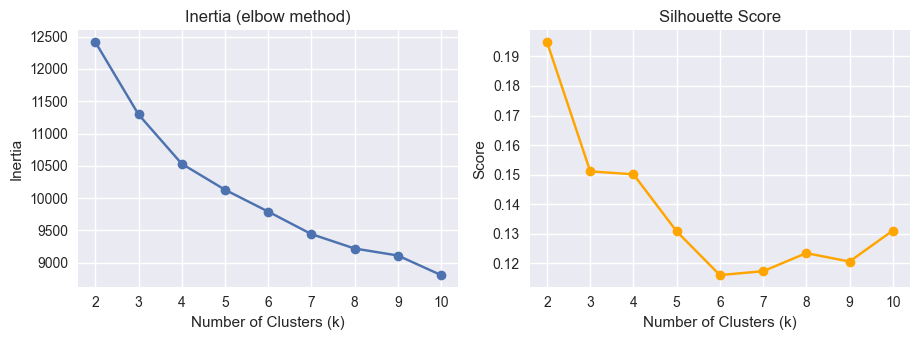

In [199]:
# Elbow method (inertia)
plt.subplot(1, 2, 1) # rows, columns, index
plt.plot(results_df['k'], results_df['inertia'], marker='o')
plt.title('Inertia (elbow method)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')

# Silhouette score
plt.subplot(1, 2, 2) # rows, columns, index
plt.plot(results_df['k'], results_df['silhouette'], marker='o', color='orange')
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Score')

plt.tight_layout()
plt.show()

How to interpret these charts:

- Inertia: Look for the "elbow" point where inertia stops decreasing sharply.
- Silhouette score: Higher is better (max = 1). Indicates well-separated clusters.

## Results

In [200]:
# Create k-means object
cluster_kmeans_4 = KMeans(n_clusters=4, random_state=0, n_init="auto")
# Train model
model_cluster_kmeans_4 = cluster_kmeans_4.fit(df_clustering_reduced)

unique_values, counts = np.unique(model_cluster_kmeans_4.labels_, return_counts=True)

# Combine into a dictionary (optional)
value_counts = dict(zip(unique_values, counts))

print(value_counts)

# Predict cluster labels
labels = model_cluster_kmeans_4.predict(df_clustering_reduced)

# Add labels to the DataFrame
df_clustering_reduced['cluster'] = labels

{0: 514, 1: 670, 2: 1468, 3: 1248}


C:\Users\fc2\AppData\Local\Temp\ipykernel_15528\3096822824.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [201]:
df_clustering_reduced.head()

,Age,Purchase Amount (USD),Review Rating,Previous Purchases,Gender_Female,Gender_Male,Category_Accessories,Category_Clothing,Category_Footwear,Category_Outerwear,...,Discount Applied_No,Discount Applied_Yes,Frequency of Purchases_Annually,Frequency of Purchases_Bi-Weekly,Frequency of Purchases_Every 3 Months,Frequency of Purchases_Fortnightly,Frequency of Purchases_Monthly,Frequency of Purchases_Quarterly,Frequency of Purchases_Weekly,cluster
Customer ID,,,,,,,,,,,,,,,,,,,,,
1,0.711538,0.4125,0.24,0.265306,0,1.0,0,1.0,0,0,...,0,1.0,0,0,0,1.0,0,0,0,2
2,0.019231,0.5500,0.24,0.020408,0,1.0,0,1.0,0,0,...,0,1.0,0,0,0,1.0,0,0,0,2
3,0.615385,0.6625,0.24,0.448980,0,1.0,0,1.0,0,0,...,0,1.0,0,0,0,0,0,0,1.0,2
4,0.057692,0.8750,0.40,0.979592,0,1.0,0,0,1.0,0,...,0,1.0,0,0,0,0,0,0,1.0,2
5,0.519231,0.3625,0.08,0.612245,0,1.0,0,1.0,0,0,...,0,1.0,1.0,0,0,0,0,0,0,2


A fast way of evaluating the hot-encoded variables

In [202]:
for cluster in sorted(df_clustering_reduced.cluster.unique()):
    print(f'Cluster: {cluster}')
    print(df_clustering_reduced.loc[df_clustering_reduced.cluster == cluster].sum())
    print()

Cluster: 0
Age                                      254.576923
Purchase Amount (USD)                      255.6875
Review Rating                                260.84
Previous Purchases                       271.102041
Gender_Female                                     0
Gender_Male                                   514.0
Category_Accessories                          514.0
Category_Clothing                                 0
Category_Footwear                                 0
Category_Outerwear                                0
Subscription Status_No                        514.0
Subscription Status_Yes                           0
Shipping Type_2-Day Shipping                   87.0
Shipping Type_Express                          76.0
Shipping Type_Free Shipping                    74.0
Shipping Type_Next Day Air                    101.0
Shipping Type_Standard                         82.0
Shipping Type_Store Pickup                     94.0
Discount Applied_No                           305.0
D

In [203]:
columns_to_transform = ['Age', 'Purchase Amount (USD)', 'Review Rating', 'Previous Purchases']
df_clustering_reduced[columns_to_transform] = minmax_scaler.inverse_transform(
    df_clustering_reduced[columns_to_transform])

C:\Users\fc2\AppData\Local\Temp\ipykernel_15528\762196336.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [204]:
df_clustering_reduced.head()


,Age,Purchase Amount (USD),Review Rating,Previous Purchases,Gender_Female,Gender_Male,Category_Accessories,Category_Clothing,Category_Footwear,Category_Outerwear,...,Discount Applied_No,Discount Applied_Yes,Frequency of Purchases_Annually,Frequency of Purchases_Bi-Weekly,Frequency of Purchases_Every 3 Months,Frequency of Purchases_Fortnightly,Frequency of Purchases_Monthly,Frequency of Purchases_Quarterly,Frequency of Purchases_Weekly,cluster
Customer ID,,,,,,,,,,,,,,,,,,,,,
1,55.0,53.0,3.1,14.0,0,1.0,0,1.0,0,0,...,0,1.0,0,0,0,1.0,0,0,0,2
2,19.0,64.0,3.1,2.0,0,1.0,0,1.0,0,0,...,0,1.0,0,0,0,1.0,0,0,0,2
3,50.0,73.0,3.1,23.0,0,1.0,0,1.0,0,0,...,0,1.0,0,0,0,0,0,0,1.0,2
4,21.0,90.0,3.5,49.0,0,1.0,0,0,1.0,0,...,0,1.0,0,0,0,0,0,0,1.0,2
5,45.0,49.0,2.7,31.0,0,1.0,0,1.0,0,0,...,0,1.0,1.0,0,0,0,0,0,0,2


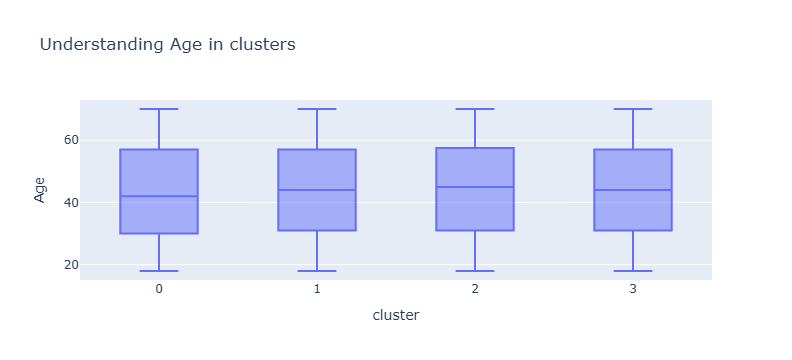

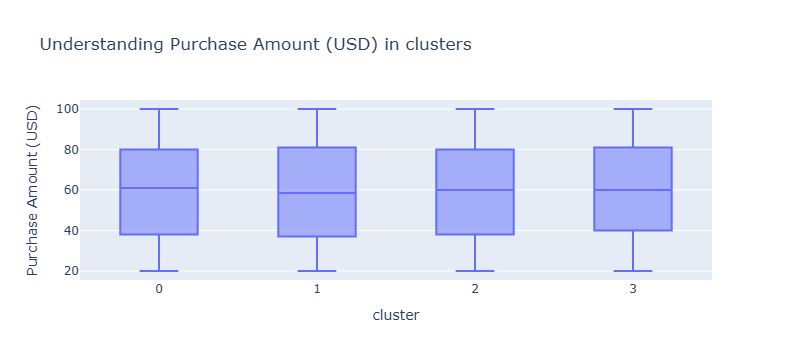

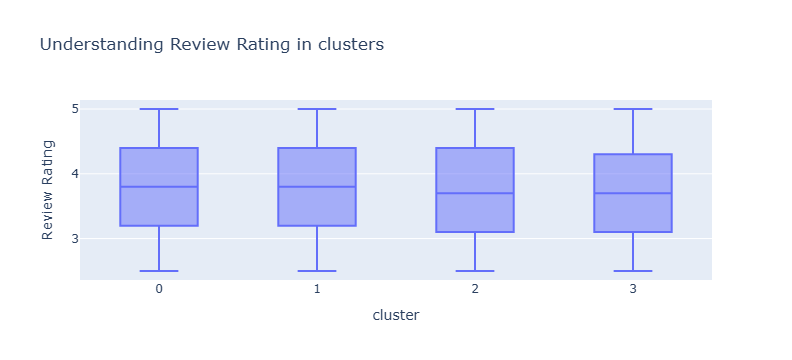

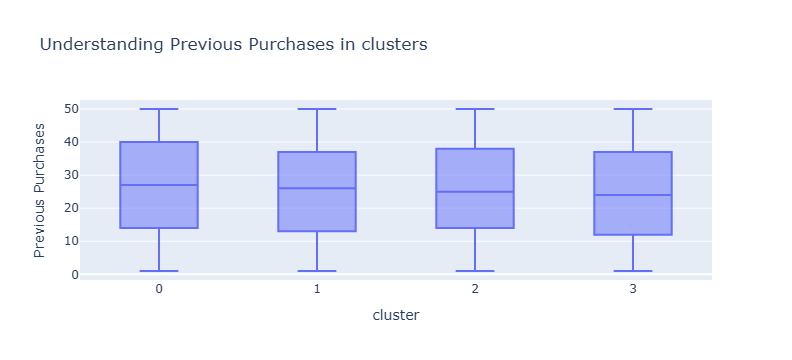

In [205]:
# Easier to code using plotly

features_to_plot = ['Age', 'Purchase Amount (USD)', 'Review Rating', 'Previous Purchases']

for feature in features_to_plot:

    figplotly = px.box(
        df_clustering_reduced,
        x='cluster',
        y=feature,
        title=f'Understanding {feature} in clusters',
        category_orders={'cluster': sorted(df_clustering_reduced.cluster.unique())}  # Alphabetical order
    )

    figplotly.update_layout(
        xaxis_title='cluster',
        yaxis_title=feature,
        #xaxis_tickangle=-45
    )

    figplotly.show()

The algorithm was not able to identify representative differences in the continuous variables to extract segments.

Algorithm segments can only be a first step for assesment:

- Cluster 3: female
- Cluster 0: male, buying accessories, not subscribed
- Cluster 1: male, not buying accessories, not subscribe
- Cluster 2: male, discount-sensitive, subscribed

# Improving model

Let's try to define some age groups and verify whether algorithm is able to identify new groups.

The choice of age groups will be based in already defined relevant age groups defined by Marketing:

- Younger population
- Adult population, career starting
- Adult population, traditional target group
- Higher age population

## Preparing new dataframe

In [206]:
younger_group = 30
adult_start_group = 40
adult_target_group = 60

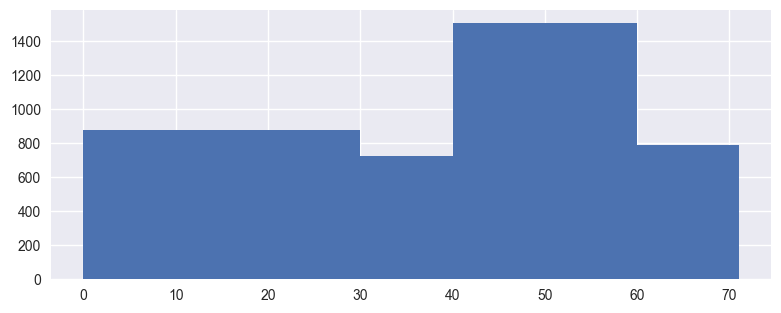

In [207]:
age_groups= [0, 
             younger_group, 
             adult_start_group, 
             adult_target_group, 
             df_clustering_reduced.Age.max() + 1
            ]

plt.hist(df_clustering_reduced.Age, bins=age_groups)
plt.show()

Create new dataframe for this new model

Need to delete the already created column 'cluster'

In [208]:
df_clustering_reduced_age_bins = df_clustering_reduced.copy()

df_clustering_reduced_age_bins = df_clustering_reduced_age_bins.drop(columns='cluster')

In [209]:
df_clustering_reduced_age_bins['Age_Younger'] = (
                        (df_clustering_reduced_age_bins.Age < younger_group)
                        ).astype(int)

df_clustering_reduced_age_bins['Age_Adult_start'] = (
                        (df_clustering_reduced_age_bins.Age >= younger_group) & 
                        (df_clustering_reduced_age_bins.Age < adult_start_group)
                        ).astype(int)

df_clustering_reduced_age_bins['Age_Adult_target'] = (
                        (df_clustering_reduced_age_bins.Age >= adult_start_group) &
                        (df_clustering_reduced_age_bins.Age < adult_target_group)
                        ).astype(int)

df_clustering_reduced_age_bins['Age_Higher'] = (
                        (df_clustering_reduced_age_bins.Age >= adult_target_group)
                        ).astype(int)

## Choosing model

In [210]:
# Not forgetting to remove 'Age' for the calculations
X = df_clustering_reduced_age_bins.drop(columns='Age')  # your feature matrix
cluster_range = range(2, 20)
results = []

for k in cluster_range:
    model = KMeans(n_clusters=k, random_state=888)
    labels = model.fit_predict(X)
    
    inertia = model.inertia_  # Sum of squared distances to cluster centers
    silhouette = silhouette_score(X, labels)  # How well-separated the clusters are
    
    results.append({'k': k, 'inertia': inertia, 'silhouette': silhouette})

results_df = pd.DataFrame(results)
print(results_df)

     k       inertia  silhouette
0    2  1.365123e+06    0.454380
1    3  1.046097e+06    0.389069
2    4  7.576246e+05    0.361808
3    5  5.791330e+05    0.377624
4    6  4.574126e+05    0.376671
5    7  4.032689e+05    0.361406
6    8  3.601604e+05    0.363896
7    9  3.256120e+05    0.339071
8   10  2.926428e+05    0.338171
9   11  2.716093e+05    0.323744
10  12  2.451756e+05    0.329550
11  13  2.223008e+05    0.337914
12  14  2.074188e+05    0.330824
13  15  1.917926e+05    0.329449
14  16  1.820986e+05    0.325993
15  17  1.735757e+05    0.324592
16  18  1.627070e+05    0.330749
17  19  1.570911e+05    0.324032


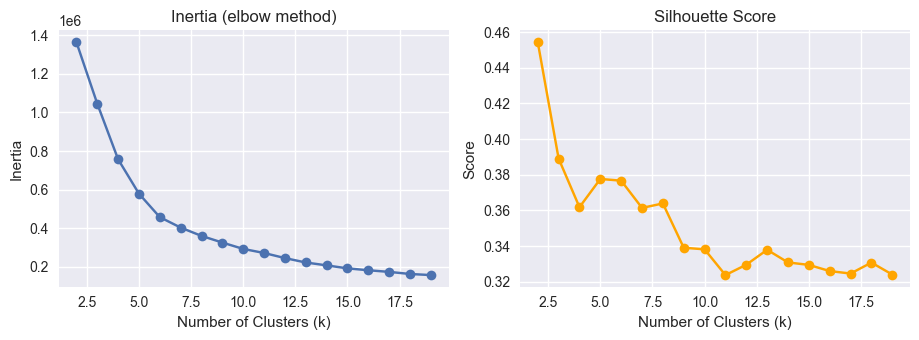

In [211]:
# Elbow method (inertia)
plt.subplot(1, 2, 1) # rows, columns, index
plt.plot(results_df['k'], results_df['inertia'], marker='o')
plt.title('Inertia (elbow method)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')

# Silhouette score
plt.subplot(1, 2, 2) # rows, columns, index
plt.plot(results_df['k'], results_df['silhouette'], marker='o', color='orange')
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Score')

plt.tight_layout()
plt.show()

There might be a 'sweet spot' with k = 6

In [212]:
# Create k-means object
cluster_kmeans_6 = KMeans(n_clusters=6, random_state=0, n_init="auto")
# Train model
model_cluster_kmeans_6 = cluster_kmeans_6.fit(df_clustering_reduced_age_bins.drop(columns='Age'))

unique_values, counts = np.unique(model_cluster_kmeans_6.labels_, return_counts=True)

# Combine into a dictionary (optional)
value_counts = dict(zip(unique_values, counts))

print(value_counts)

# Predict cluster labels
labels = model_cluster_kmeans_6.predict(df_clustering_reduced_age_bins.drop(columns='Age'))

# Add labels to the DataFrame
df_clustering_reduced_age_bins['cluster'] = labels

{0: 628, 1: 633, 2: 704, 3: 665, 4: 641, 5: 629}


## Findings

In [213]:
for cluster in sorted(df_clustering_reduced_age_bins.cluster.unique()):
    print(f'Cluster: {cluster}')
    print(df_clustering_reduced_age_bins.loc[df_clustering_reduced_age_bins.cluster == cluster].sum())
    print()

Cluster: 0
Age                                      28345.0
Purchase Amount (USD)                    55577.0
Review Rating                             2376.6
Previous Purchases                       23773.0
Gender_Female                              198.0
Gender_Male                                430.0
Category_Accessories                       193.0
Category_Clothing                          294.0
Category_Footwear                           92.0
Category_Outerwear                          49.0
Subscription Status_No                     446.0
Subscription Status_Yes                    182.0
Shipping Type_2-Day Shipping               106.0
Shipping Type_Express                      117.0
Shipping Type_Free Shipping                 99.0
Shipping Type_Next Day Air                  89.0
Shipping Type_Standard                     107.0
Shipping Type_Store Pickup                 110.0
Discount Applied_No                        360.0
Discount Applied_Yes                       268.0
Frequency

Comments:

- From this segmentation, no obvious interpretation can be applied.
- This suggests both defining new features and get counseling from expert knowledge to get more interpretation insights
- Some visual exploration of clustering might help, as a first step

In [214]:
df_clustering_reduced_age_bins['cluster'] = df_clustering_reduced_age_bins.cluster.astype(str)

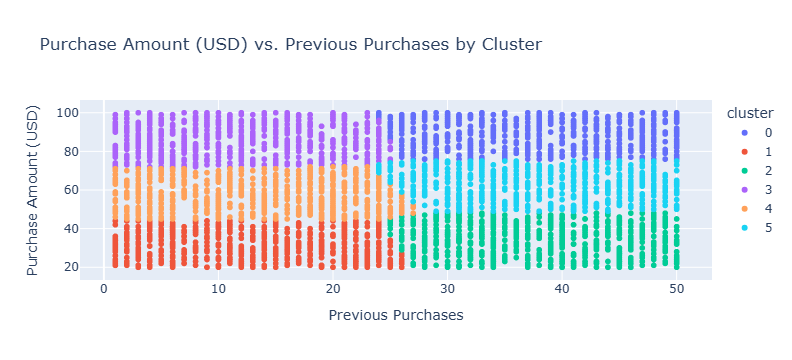

In [215]:
figplotly = px.scatter(
    df_clustering_reduced_age_bins,
    x='Previous Purchases',
    y='Purchase Amount (USD)',
    color='cluster',
    title='Purchase Amount (USD) vs. Previous Purchases by Cluster',
    labels={'review': 'Review Score', 'usd': 'Price in USD', 'label': 'Category Label'}, 
    category_orders={'cluster': sorted(df_clustering_reduced_age_bins.cluster.unique())}  # Alphabetical order
)

figplotly.show()


# Conclusions

Alone with K Means, segmentation for unknown data is only a starting point to boost creativity for further data exploration ideas.

However, the unsupervised clustering model with some initial feature engineering allows to cluster customers in a way that will predict the future purchase amount with previous purchases.

That insight is very powerful.